# Circuit from YAML
> Sometimes it's useful to be able to define circuits from YAML definitions. To not re-invent the wheel, SAX uses [GDSFactory](https://gdsfactory.readthedocs.io/en/latest/yaml.html)'s YAML netlist spec to define its circuits. This makes it very easy to convert a GDSFactory layout to a SAX circuit model!

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sax
import yaml

## MZI

Let's first see how we can define a SAX circuit from YAML:

In [2]:
netlist = """
instances:
    lft:
      component: coupler
      settings:
          coupling: 0.5
    rgt:
        component: coupler
        settings:
            coupling: 0.5
    top:
        component: straight
        settings:
            length: 25.0
    btm:
        component: straight
        settings:
            length: 15.0

connections:
    lft,out0: btm,in0
    btm,out0: rgt,in0
    lft,out1: top,in0
    top,out0: rgt,in1

ports:
    in0:  lft,in0
    in1:  lft,in1
    out0: rgt,out0
    out1: rgt,out1

"""

In [3]:
yaml.safe_load(netlist)

{'instances': {'lft': {'component': 'coupler', 'settings': {'coupling': 0.5}},
  'rgt': {'component': 'coupler', 'settings': {'coupling': 0.5}},
  'top': {'component': 'straight', 'settings': {'length': 25.0}},
  'btm': {'component': 'straight', 'settings': {'length': 15.0}}},
 'connections': {'lft,out0': 'btm,in0',
  'btm,out0': 'rgt,in0',
  'lft,out1': 'top,in0',
  'top,out0': 'rgt,in1'},
 'ports': {'in0': 'lft,in0',
  'in1': 'lft,in1',
  'out0': 'rgt,out0',
  'out1': 'rgt,out1'}}

In [4]:
mzi, _ = sax.circuit(
    yaml.safe_load(netlist),
    models={"coupler": sax.models.coupler, "straight": sax.models.straight},
)

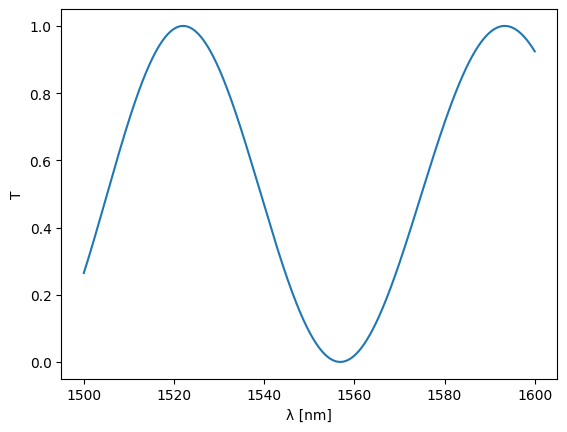

In [5]:
wl = jnp.linspace(1.5, 1.6, 1000)
transmission = jnp.abs(mzi(wl=wl)["in0", "out0"]) ** 2

plt.plot(wl * 1e3, transmission)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.show()

That was easy! However, during the above YAML conversion, only models available in `sax.models` were used. What if we want to map the YAML component names to custom models? Let's say we want to use a dispersionless waveguide for the above model for example:

In [6]:
def waveguide_without_dispersion(wl=1.55, length=25.0, neff=2.34):
    phase = 2 * jnp.pi * neff * length / wl
    sdict = sax.reciprocal({("in0", "out0"): jnp.exp(1j * phase)})
    return sdict

We can regenerate the above circuit again, but this time we specify a models mapping:

In [7]:
mzi, _ = sax.circuit(
    yaml.safe_load(netlist),
    models={"straight": waveguide_without_dispersion, "coupler": sax.models.coupler},
)

> The `models=` keyword in `circuit_from_yaml` can be a dictionary **or** an imported python module (like for example `sax.models`). Or a list containing multiple of such dictionary mappings and imported modules.

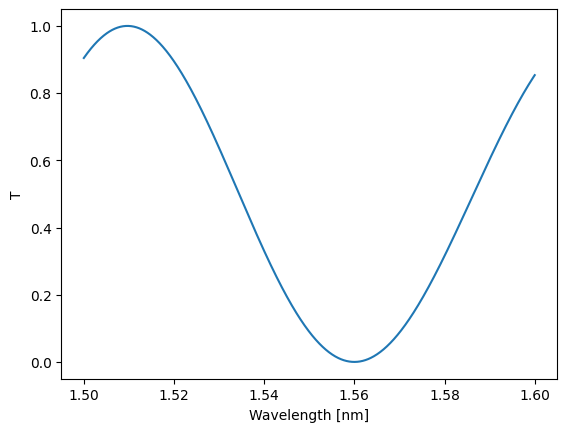

In [8]:
wl = jnp.linspace(1.5, 1.6, 1000)
transmission = jnp.abs(mzi(wl=wl)["in0", "out0"]) ** 2

plt.plot(wl, transmission)
plt.xlabel("Wavelength [nm]")
plt.ylabel("T")
plt.show()